## 1. Packages

In [ ]:
using Agents
using Random
using Statistics
using StatsBase
using Plots

## 2. Agent definition 



In [2]:
@agent struct Labs(NoSpaceAgent)
    power::Float64           # statistical power
    effort::Float64          # effort level
    false_pos_rate::Float64  # α-equivalent for this lab, given power & effort
    pub_payoff::Float64      # publication payoff (number/weight of pubs)
    age::Int                 # age in time steps
end

## 3. Core mechanisms - Scientific production, mutation, and evolutionary dynamics.


In [ ]:
function do_science!(agent, model)
    # start a new study?
    if rand() < 1 .- model.effort_influence * log10(agent.effort) # probability of starting a new hypothesis
        # underlying truth of the hypothesis for this study
        actual_truth = rand() < model.base_rate

        if actual_truth
            # Hypothesis actually true
            if rand() < agent.power
                # true positive
                agent.pub_payoff += 1
            else
                # false negative, maybe published
                if rand() < model.prob_publish_neg_result
                    agent.pub_payoff += model.payoff_neg_result
                end
            end
        else
            # Hypothesis actually false
            if rand() < agent.false_pos_rate
                # false positive
                agent.pub_payoff += 1
            else
                # true negative, maybe published
                if rand() < model.prob_publish_neg_result
                    agent.pub_payoff += model.payoff_neg_result
                end
            end
        end
    end
end

do_science! (generic function with 1 method)

In [ ]:

function mutate!(agent, model)
    # mutate power
    if rand() < model.mutation_rate_power
        agent.power += randn() * model.mutation_SD_power
        agent.power = clamp(agent.power, 0.0, 1.0)
    end

    # mutate effort
    if rand() < model.mutation_rate_effort
        agent.effort += randn() * model.mutation_SD_effort
        agent.effort = clamp(agent.effort, 1.0, 100.0)
    end

    # recompute false positive rate from power & effort
    agent.false_pos_rate = agent.power / (1 + ((1 - agent.power) * agent.effort))
end



mutate! (generic function with 1 method)

In [ ]:
# pick one of the max values, breaking ties randomly
function max_one_of_random(xs, f)
    vals = map(f, xs)
    m = maximum(vals)
    ties = findall(==(m), vals)
    return xs[rand(ties)]
end

function evolution!(model)
    reproduction_samplesize = Int(round(model.reproduction_samplesize))

    # death
    labs = collect(allagents(model))
    if !isempty(labs)
        sample_size = min(reproduction_samplesize, length(labs))
        if sample_size > 0
            death_labs = sample(labs, sample_size; replace=false)
            if !isempty(death_labs)
                oldest_lab = max_one_of_random(death_labs, a -> a.age)
                remove_agent!(oldest_lab, model)
            end
        end
    end

    # birth
    labs = collect(allagents(model))
    if !isempty(labs)
        sample_size = min(reproduction_samplesize, length(labs))
        if sample_size > 0
            birth_labs = sample(labs, sample_size; replace=false)
            if !isempty(birth_labs)
                fanciest_lab = max_one_of_random(birth_labs, a -> a.pub_payoff)

                offspring = add_agent!(model;
                    power=fanciest_lab.power,
                    effort=fanciest_lab.effort,
                    false_pos_rate=fanciest_lab.power / (1 + ((1 - fanciest_lab.power) * fanciest_lab.effort)),
                    pub_payoff=0.0,
                    age=0,
                )
                mutate!(offspring, model)
            end
        end
    end
end



evolution! (generic function with 1 method)

## 4. Helper - fdr

In [ ]:
# Compute the false discovery rate of published results in the model
function false_discovery_rate(model)
    labs = collect(allagents(model))
    pow = mean(a -> a.power, labs)
    fpr = mean(a -> a.false_pos_rate, labs)

    total_pubs = model.base_rate * (pow + (1 - pow) * model.prob_publish_neg_result) + (1 - model.base_rate) * (fpr + (1 - fpr) * model.prob_publish_neg_result)

    false_pubs = model.base_rate * (1 - pow) * model.prob_publish_neg_result + (1 - model.base_rate) * fpr

    return false_pubs / total_pubs
end



false_discovery_rate (generic function with 1 method)

## 4. Dynamics - agent_step! - model_step!

In [ ]:
function agent_step!(agent, model)
    do_science!(agent, model)
end

function model_step!(model)
    evolution!(model)
    model.fdr = false_discovery_rate(model)
    for agent in allagents(model)
        agent.age += 1
    end
end

model_step! (generic function with 1 method)

## 5. Model initialization

In [ ]:
function initialize(;
    num_labs::Int=100,
    effort_influence::Float64=0.2,
    reproduction_samplesize::Float64=10.0,
    base_rate::Float64=0.1,
    effort_init::Float64=75.0,
    power_init::Float64=0.8,
    prob_publish_neg_result::Float64=0.0,
    payoff_neg_result::Float64=0.0,
    mutation_rate_effort::Float64=0.1,
    mutation_rate_power::Float64=0.01,
    mutation_SD_effort::Float64=1.0,
    mutation_SD_power::Float64=0.01,
)

    properties = Dict(
        :effort_influence => effort_influence,
        :reproduction_samplesize => reproduction_samplesize,
        :base_rate => base_rate,
        :prob_publish_neg_result => prob_publish_neg_result,
        :payoff_neg_result => payoff_neg_result,
        :mutation_rate_effort => mutation_rate_effort,
        :mutation_rate_power => mutation_rate_power,
        :mutation_SD_effort => mutation_SD_effort,
        :mutation_SD_power => mutation_SD_power,
        :fdr => 0.0,
    )

    model = StandardABM(
        Labs;
        properties=properties,
        (agent_step!)=agent_step!,
        (model_step!)=model_step!,
        scheduler=Schedulers.Randomly(),
    )

    for _ in 1:num_labs
        add_agent!(model;
            power=power_init,
            effort=effort_init,
            false_pos_rate=power_init / (1 + ((1 - power_init) * effort_init)),
            pub_payoff=0.0,
            age=0,
        )
    end

    model.fdr = false_discovery_rate(model)
    return model
end



initialize (generic function with 1 method)

## 6. Helper - running simulations

In [ ]:
function run_trial(effort_influence, mutation_rate_effort, mutation_rate_power; max_steps = 80000)
    model = initialize(effort_influence = effort_influence, mutation_rate_effort = mutation_rate_effort, mutation_rate_power = mutation_rate_power)

    ts_data = Vector{NTuple{5,Float64}}(undef, max_steps)

    for t in 1:max_steps
        step!(model, 1)

        labs = collect(allagents(model))
        effs = [a.effort for a in labs]
        pows = [a.power for a in labs]
        fprs = [a.false_pos_rate for a in labs]

        m_eff = mean(effs)
        m_pow = mean(pows)
        m_fpr = mean(fprs)
        fdr   = false_discovery_rate(model)

        ts_data[t] = (t, m_eff, m_pow, m_fpr, fdr)
    end

    return ts_data
end

run_trial (generic function with 1 method)

## 6. Helper - build plot

In [ ]:

function sample_run_plot(; effort_influence=0.2, mutation_rate_effort=0.1, mutation_rate_power=0.01, max_steps=80000)
    ts_data = run_trial(effort_influence, mutation_rate_effort, mutation_rate_power; max_steps=max_steps)

    times = [row[1] for row in ts_data]
    m_effort = [row[2] for row in ts_data]
    m_power = [row[3] for row in ts_data]
    m_fpr = [row[4] for row in ts_data]
    fdr = [row[5] for row in ts_data]


    maxpts = 10000   # reduce to this number of points to draw because plotting all is slow; max = max_steps 
    step = max(1, length(times) ÷ maxpts)
    idx = 1:step:length(times)

    t = times[idx]
    pwr = m_power[idx]
    fpr = m_fpr[idx]
    fd = fdr[idx]
    eff = m_effort[idx]


    plt1 = plot(
        t, pwr;
        label="power",
        title="Power and false positives",
        xlabel="time",
        ylabel="",
        ylim=(0, 1),
        legend=:bottomright,
    )
    plot!(plt1, t, fpr; label="false pos")
    plot!(plt1, t, fd; label="false disc")

    plt2 = plot(
        t, eff;
        label="effort",
        title="Effort",
        xlabel="time",
        ylabel="effort",
        ylim=(0, 100),
        legend=false,
    )

    combined = plot(plt1, plt2; layout=(2, 1), size=(800, 900))
    display(combined)
end


sample_run_plot (generic function with 1 method)

## 8. Simulate and plot


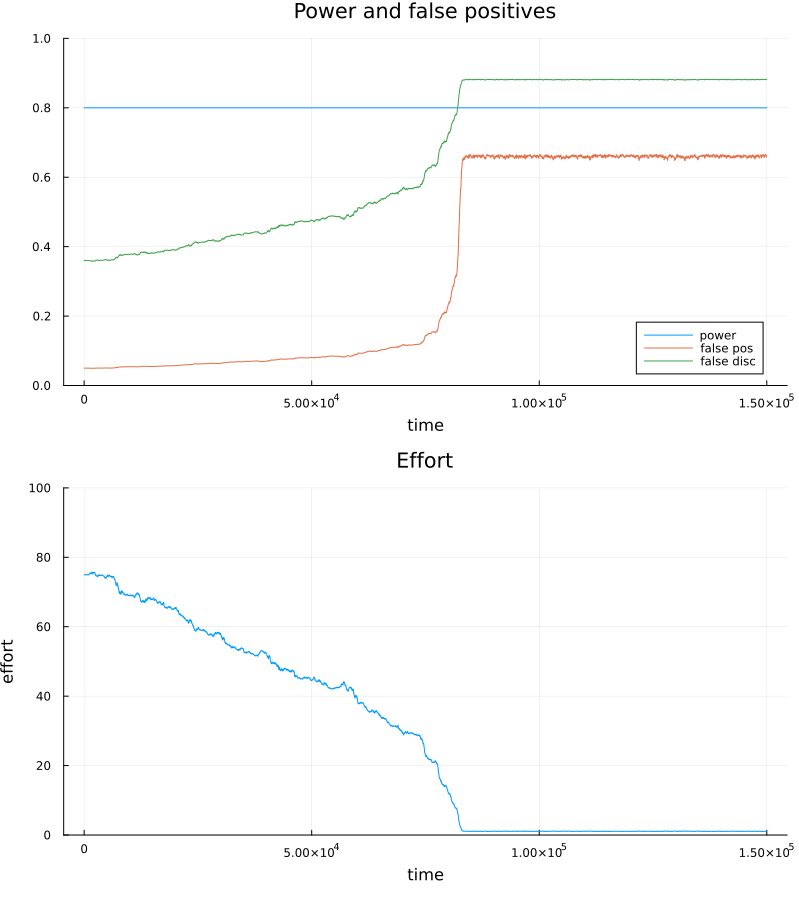

In [14]:
# Fig 8.9 top
sample_run_plot(effort_influence = 0.2, mutation_rate_effort = 0.1, mutation_rate_power = 0.00, max_steps = 150000) # adjust parameters here

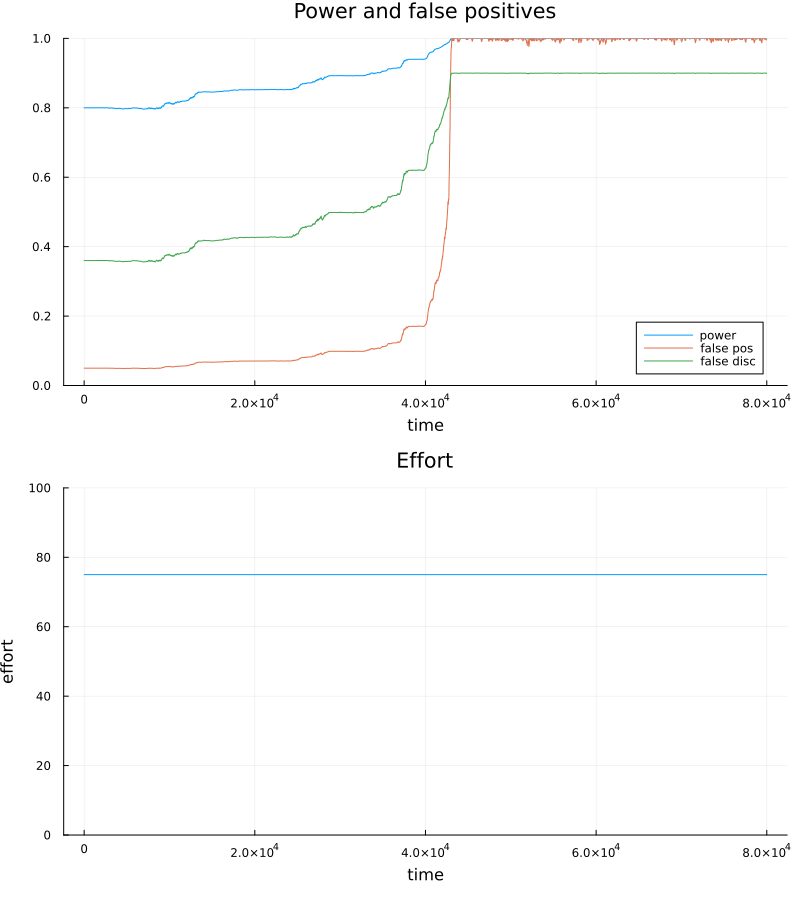

In [12]:
# Fig 8.9 bottom
sample_run_plot(effort_influence = 0.2, mutation_rate_effort = 0.0, mutation_rate_power = 0.01, max_steps = 80000) # adjust parameters here